In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

from matplotlib.colors import LinearSegmentedColormap
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):
            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(np.reshape(profile_cf_anoms, (15,12,24*144,221)), axis=2)
    profile_cf_anoms_ts = np.reshape(profile_cf_anoms_zm, (180,221))[5:]
    return(profile_cf_anoms_ts)

def corr_matrix_plotter(corr_matrx):
    correlation_matrix = corr_matrx[:,:,0]
    correlation_matrix = np.around(correlation_matrix, 2)
    significance_matrix = corr_matrx[:,:,1] 

    # Significance will be dictated in Correlation Matrix with '*'
    sig_str = []
    for row in significance_matrix:
        row_str = []
        for item in row:
            if int(item) == 1:
                row_str.append('*')
            else:
                row_str.append(' ')
        sig_str.append(row_str)
    sig_str = np.array(sig_str)

    corr = correlation_matrix.astype(str)
    matrix = np.triu(np.ones_like(corr_matrx))
    plt.figure(figsize=(len(correlation_matrix),len(correlation_matrix)))
    sns.set_palette("Paired")
    sns.color_palette("Paired")
    # combining text with values
    formatted_text = (np.asarray(["{corr}{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())])).reshape(len(correlation_matrix), len(correlation_matrix))
    #formatted_text = (print(np.asarray(["{corr}\n{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())]))).reshape(8, 8)
    # plot the heatmap
    matrix = np.triu(np.ones_like(significance_matrix))
    ax = sns.heatmap(correlation_matrix, xticklabels=predictors_and_target_df.columns, 
                yticklabels=predictors_and_target_df.columns, cmap=custom_cmap, 
                annot=formatted_text,  vmin=-1, vmax=1, fmt="",
                annot_kws={"fontsize":12}, mask=matrix, cbar=False)
    for i in range(0, len(matrix)-1):
        for j in range(1, len(matrix[i])):
            if int(matrix[i,j]) == 0:
                continue
            elif i == j:
                continue
            else:
                ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='black', lw=1.5))
    return(ax)

def lr_table(X, Y1, Y2, Y3, Y4, Y5):
    X = sm.add_constant(X) # adding a constant
    
    lm1 = pg.linear_regression(X, Y1, add_intercept=True, relimp=True)
    lm1 = lm1[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm1 = lm1.round(2)
    r2_y1 = lm1.r2[0]
    adjr2_y1 = lm1.adj_r2[0]
    #################################################################
    lm2 = pg.linear_regression(X, Y2, add_intercept=True, relimp=True)
    lm2 = lm2[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm2 = lm2.round(2)
    r2_y2 = lm2.r2[0]
    adjr2_y2 = lm2.adj_r2[0]
    #################################################################
    lm3 = pg.linear_regression(X, Y3, add_intercept=True, relimp=True)
    lm3 = lm3[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm3 = lm3.round(2)
    r2_y3 = lm3.r2[0]
    adjr2_y3 = lm3.adj_r2[0]
    #################################################################
    lm4 = pg.linear_regression(X, Y4, add_intercept=True, relimp=True)
    lm4 = lm4[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm4 = lm4.round(2)
    r2_y4 = lm4.r2[0]
    adjr2_y4 = lm4.adj_r2[0]
    #################################################################
    lm5 = pg.linear_regression(X, Y5, add_intercept=True, relimp=True)
    lm5 = lm5[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm5 = lm5.round(2)
    r2_y5 = lm5.r2[0]
    adjr2_y5 = lm5.adj_r2[0]
    
    new_df = [
              ['  CPT  ', str(lm1.coef[1]) + '/' + str(lm1.relimp[1]), str(lm1.coef[2]) + '/' +  str(lm1.relimp[2]), str(lm1.coef[3]) + '/' +  str(lm1.relimp[3]), r2_y1, adjr2_y1], 
              ['  CPZ  ', str(lm5.coef[1]) + '/' + str(lm5.relimp[1]), str(lm5.coef[2]) + '/' +  str(lm5.relimp[2]), str(lm5.coef[3]) + '/' +  str(lm5.relimp[3]), r2_y5, adjr2_y5], 
              ['  WV  ',str(lm3.coef[1]) + '/' + str(lm3.relimp[1]), str(lm3.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm3.coef[3]) + '/' +  str(lm3.relimp[3]), r2_y3, adjr2_y3],
              ['  TCF  ',str(lm2.coef[1]) + '/' + str(lm2.relimp[1]), str(lm2.coef[2]) + '/' +  str(lm2.relimp[2]), str(lm2.coef[3]) + '/' +  str(lm2.relimp[3]), r2_y2, adjr2_y2],
              ['  ACF  ',str(lm4.coef[1]) + '/' + str(lm4.relimp[1]), str(lm4.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm4.coef[3]) + '/' +  str(lm4.relimp[3]), r2_y4, adjr2_y4]]
    
    new_df = pd.DataFrame(new_df)
    new_df.columns = ['       ', ' QBO ', ' BDC ', ' ENSO ', 'R2', 'adj R2']    
    table_text = new_df.to_latex(index=False, na_rep='NA')
    #table_text_w_caption = table_text[:19] + '\n\caption {$R^{2}$ = } \label{tab:title} ' + table_text[19:]
    print(table_text)

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
#cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()


cpts = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/cpts.nc')['__xarray_dataarray_variable__'].values
cpzs = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/cpzs.nc')['__xarray_dataarray_variable__'].values
total_cf = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/total_cf.nc')['__xarray_dataarray_variable__'].values
profiles_cf = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/profiles_cf.nc')['__xarray_dataarray_variable__'].values
temp_profs = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/temp_profs.nc')['__xarray_dataarray_variable__'].values
allTCFCalendarMaps = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/allTCFCalendarMaps.nc')['__xarray_dataarray_variable__'].values
wv_calendar = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/wv_calendar.nc')['__xarray_dataarray_variable__'].values
o3_calendar = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/o3_calendar.nc')['__xarray_dataarray_variable__'].values

qbo_ts = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/qbo_ts.nc')['__xarray_dataarray_variable__'].values
mjo = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/mjo.nc')['__xarray_dataarray_variable__'].values
BDC_EHF = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/BDC_EHF.nc')['__xarray_dataarray_variable__'].values
T500 = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/T500.nc')['__xarray_dataarray_variable__'].values
w_star = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/w_star.nc')['__xarray_dataarray_variable__'].values

cpz_maps_zm_annual_mean = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/cpz_annual_zonal_mean.npy')
lrz_maps_zm_annual_mean = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/TTLVariabilityData/lrz_annual_zonal_mean.npy')

In [3]:
# get tropical temperature profs and cpt
temp_profs_TTL = temp_profs[:,:,24:48,:,70:170]
cpts_TTL = cpts.copy()
cpzs_TTL = cpzs.copy()

# also get the vertical temperature gradient
vert_temp_grad_profs = tool_box.vert_temp_gradient(temp_profs_TTL)

# Find anomalies or reshape indices 
cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpzs_anomalies = tool_box.anomaly_finder(cpzs_TTL)
temp_anomalies = tool_box.anomaly_finder(temp_profs_TTL)
vert_tempGrad_anomalies = tool_box.anomaly_finder(vert_temp_grad_profs)
vert_tanomGrad_anomalies = tool_box.vert_temp_gradient(temp_anomalies)
total_cf_anomalies = tool_box.anomaly_finder(total_cf)
allTCF_anomalies = tool_box.anomaly_finder(allTCFCalendarMaps)
profile_cf_anomalies = tool_box.anomaly_finder(profiles_cf)
wv_calendar_anoms = wv_calendar - np.nanmean(wv_calendar, axis=0)
wv_anoms_16NS_UTLS = np.nanmean(wv_calendar_anoms[:,:,:,19:26], axis=3)
wv_calendar_ts = np.reshape(wv_anoms_16NS_UTLS, (17*12,55))[1:-11]
wv_ts_ = wv_calendar_ts[:,13]

# Find the average over 15S-15N
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpz_tropical_mean = tool_box.tropical_average(cpzs_anomalies)
temps_tropical_mean = tool_box.tropical_average(temp_anomalies)
vert_tempGrad_tropical_mean = tool_box.tropical_average(vert_tempGrad_anomalies)
vert_tanomGrad_tropical_mean = tool_box.tropical_average(vert_tanomGrad_anomalies)
total_cf_tropical_mean = tool_box.tropical_average(total_cf_anomalies[:,:,:,:])
profile_cf_tropical_mean = tool_box.tropical_average(profile_cf_anomalies)
allcfTCF_tropical_mean = tool_box.tropical_average(allTCF_anomalies)

# pull in ozone data
o3_calendar = o3_calendar - np.nanmean(o3_calendar, axis=0)
o3_calendar_ts = np.reshape(o3_calendar, (17*12,55,45))[12:]
o3_calendar = np.reshape(o3_calendar_ts, (16,12,55,45))
o3_ts_anoms_data = np.reshape(o3_calendar, (16*12,55,45))
o3_anoms_ts = np.reshape(o3_ts_anoms_data, (192,55,45))
o3_equatorial_anoms = np.nanmean(o3_anoms_ts[:,13,19:26], axis=1)

/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:109: RuntimeWarning: Mean of empty slice
  dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:85: RuntimeWarning: Mean of empty slice
  seasonal_average = np.nanmean(data_calendar, axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:138: RuntimeWarning: invalid value encountered in true_divide
  tropical_mean = np.nansum(tropical_data_reshaped, axis=2)/np.nansum(tropical_weights_reshaped, axis=2)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:133: RuntimeWarning: invalid value encountered in true_divide
  nanned_w

In [4]:
# The targets we want to predict
cpt_ts = cpt_tropical_mean.ravel()[5:]
cpz_ts = cpz_tropical_mean.ravel()[5:]
ttl_cirrus_cf_ts = total_cf_tropical_mean.ravel()[5:]
allcfTCF_ts = allcfTCF_tropical_mean.ravel()[5:]
wv_ts = wv_ts_[5:]
o3_ts = o3_equatorial_anoms[5:]

# Large Scale Dynamics w/leads
mjo = mjo[-187:]
T500 = T500[-187:]
qbo_cal = qbo_ts.reshape(16,12)
qbo_cal_anoms = qbo_cal - np.nanmean(qbo_cal, axis=0)
qbo_cal_anoms_ts = qbo_cal_anoms.ravel()
qbo = qbo_cal_anoms_ts[-189:-2]

# get total mass and then calculate upwelling
def z_(p):
    p0 = 1000 # hPa (reference pressure)
    H = 7000 # m (scale height)
    z = H*np.log(p0/p)
    return z
scale_height_relative = z_(100)/7000
density = 1.255 #kg/m3
density_at_100hPa = np.exp(-1*scale_height_relative)*1.255
a = 6.378e6
area_between_lats = 2*np.pi*(a**2)*(np.sin(np.deg2rad(15)) - np.sin(np.deg2rad(-15)))
total_mass = density_at_100hPa*area_between_lats
w_star_cal = w_star.reshape(16,12)*total_mass
w_star_anoms = w_star_cal - np.nanmean(w_star_cal, axis=0)
w_star_anoms_ts = w_star_anoms.ravel()
w_star_anoms_ts = w_star_anoms_ts[-187:]
raw_upwelling_mf_100hPa = w_star_anoms_ts
upwelling_mf_100hPa = w_star_anoms_ts

bdc_ehf_cal = BDC_EHF.reshape(16,12)
bdc_ehf_cal_anoms = bdc_ehf_cal - np.nanmean(bdc_ehf_cal, axis=0)
bdc_ehf_cal_anoms_ts = bdc_ehf_cal_anoms.ravel()
bdc_ehf = bdc_ehf_cal_anoms_ts[-187:]


# Time Series Visualizations

Text(0.5, 1.0, 'Standardized Interannual Anomalies of 15$\\degree$S-15$\\degree$N CPT, WV83, and TTLCCF')

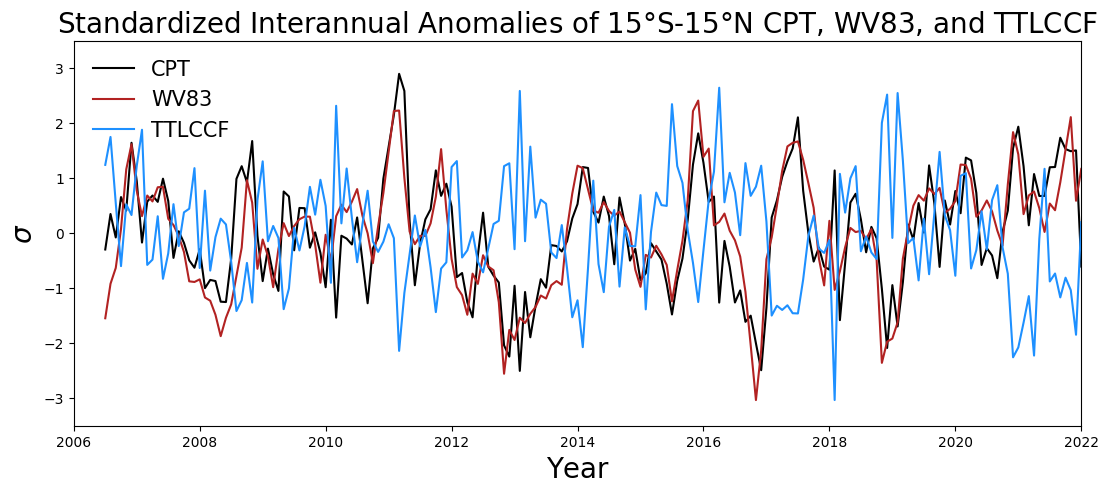

In [5]:
plt.figure(figsize=(13,5))
times = np.linspace(2006.5,2022,187)
plt.plot(times, cpt_ts/np.nanstd(cpt_ts), label="CPT", color='Black')
plt.plot(times, wv_ts/np.nanstd(wv_ts), label="WV83", color='firebrick')
plt.plot(times, ttl_cirrus_cf_ts/np.nanstd(ttl_cirrus_cf_ts), label="TTLCCF", color='dodgerblue')

plt.legend(frameon=False, fontsize=15, loc=2)
plt.ylim(-3.5,3.5)
plt.xlim(2006,2022)
plt.ylabel('$\sigma$', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Standardized Interannual Anomalies of 15$\degree$S-15$\degree$N CPT, WV83, and TTLCCF', fontsize=20)

# Correlation Matrix

In [6]:
def trend_finder(array_of_data):
    time = np.arange(200.6, 202.2, 1/120)[5:] # time (in decades)
    trends_and_significance = []
    all_detrended_timeseries = []
    idx = 0
    for ts in array_of_data:
        idx += 1
        regression = stats.linregress(time, ts)

        # find residual timeseries
        ts_trend = regression[0]
        temp_linear_trend = regression[1] + ts_trend*time
        errors = ts - temp_linear_trend

        # find degrees of freedom with autocorrelation
        N = len(ts)
        r1_autocorrelation = stats.pearsonr(ts[1:], ts[:-1])[0]
        r2_autocorrelation = stats.pearsonr(time[1:], time[:-1])[0]
        
        N_star = N*((1-r1_autocorrelation)/
                    (1+r1_autocorrelation))
        # find squared error in x and y
        sum_squared_error_res = np.sum(np.square(errors))
        sum_squared_error_times = np.sum(np.square(time - np.nanmean(time)))
        simga_slope_squared = (1/N_star)*(sum_squared_error_res/sum_squared_error_times)
        sigma_slope = np.sqrt(simga_slope_squared)

        # get critical t value
        tcrit = stats.t.ppf(1-0.025, N_star)

        # test for significance
        b_below = ts_trend - tcrit*sigma_slope
        b_above = ts_trend + tcrit*sigma_slope

        if b_above*b_below > 0:
            significant = 1
        else:
            significant = 0

        trends_and_significance.append([ts_trend, significant])
        detrended_timeseries = ts - temp_linear_trend
        all_detrended_timeseries.append(detrended_timeseries)

    return(all_detrended_timeseries, trends_and_significance)


predictors_and_target = np.array([cpt_ts, cpz_ts, wv_ts, ttl_cirrus_cf_ts, allcfTCF_ts, o3_ts, qbo, bdc_ehf, upwelling_mf_100hPa, T500, mjo, raw_upwelling_mf_100hPa])

all_detrended_timeseries, trends_and_significance = trend_finder(predictors_and_target)
names = ['CPT (K/Decade)', 'CPZ(km/Decade)', 'WV83()', 'TTLCCF', 'ALLCF', 'O383', 'QBO', 'BDC', 'UP100', 'T500', 'MJO', 'rawUP100']
for x in range(0, len(trends_and_significance)):
    print(names[x], trends_and_significance[x])

CPT (K/Decade) [0.15994645896558085, 0]
CPZ(km/Decade) [0.06007915734786057, 0]
WV83() [1.331671669582669e-07, 0]
TTLCCF [-0.006609961676369911, 0]
ALLCF [-0.017641990379532905, 1]
O383 [1.8741292468679052e-09, 0]
QBO [0.4053266167095255, 0]
BDC [-0.06349421341960115, 0]
UP100 [320651446.12255234, 0]
T500 [0.3185650149555341, 0]
MJO [0.010237506632121949, 0]
rawUP100 [320651446.12255234, 0]


In [7]:
detrended_upwelling = all_detrended_timeseries[-4]
detrended_qbo = all_detrended_timeseries[-6]
detrended_T500 = all_detrended_timeseries[-3]
detrended_bdc = all_detrended_timeseries[-5]

upwelling_df = pd.DataFrame(np.transpose([detrended_bdc, detrended_T500, detrended_qbo, detrended_upwelling]), columns=['BDC', 'T500', 'QBO', 'upwelling'])
upwelling_MLR = pg.linear_regression(upwelling_df[['QBO', 'BDC', 'T500']], upwelling_df['upwelling'], relimp=True)
qbo_enso_bdc_fit = upwelling_MLR.coef[0] + upwelling_df['QBO']*upwelling_MLR.coef[1] + upwelling_df['BDC']*upwelling_MLR.coef[2] + upwelling_df['T500']*upwelling_MLR.coef[3] 
UpwellingRemovedFit = detrended_upwelling - qbo_enso_bdc_fit
all_detrended_timeseries[-4] = UpwellingRemovedFit

"""T500_df = pd.DataFrame(np.transpose([detrended_bdc, detrended_qbo, all_detrended_timeseries[-1], detrended_T500]), columns=['BDC', 'QBO', 'UP100', 'T500'])
T500_MLR = pg.linear_regression(T500_df[['QBO', 'BDC', 'UP100']], T500_df['T500'], relimp=True)
T500_fit = T500_MLR.coef[0] + T500_df['QBO']*T500_MLR.coef[1] + T500_df['BDC']*T500_MLR.coef[2] + T500_df['UP100']*T500_MLR.coef[3] 
all_detrended_timeseries[-3] = detrended_T500 - T500_fit"""

"T500_df = pd.DataFrame(np.transpose([detrended_bdc, detrended_qbo, all_detrended_timeseries[-1], detrended_T500]), columns=['BDC', 'QBO', 'UP100', 'T500'])\nT500_MLR = pg.linear_regression(T500_df[['QBO', 'BDC', 'UP100']], T500_df['T500'], relimp=True)\nT500_fit = T500_MLR.coef[0] + T500_df['QBO']*T500_MLR.coef[1] + T500_df['BDC']*T500_MLR.coef[2] + T500_df['UP100']*T500_MLR.coef[3] \nall_detrended_timeseries[-3] = detrended_T500 - T500_fit"

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,8.161051e-16,0.061974,1.316849e-14,1.000000e+00,0.293295,0.285613,-0.122271,0.122271,NaN,NaN
1,BDC_EHF,-4.206779e-01,0.061974,-6.787963e+00,1.514481e-10,0.293295,0.285613,-0.542949,-0.298407,0.176970,60.338598
2,BDC_PSB,-3.410642e-01,0.061974,-5.503334e+00,1.236814e-07,0.293295,0.285613,-0.463335,-0.218793,0.116325,39.661402


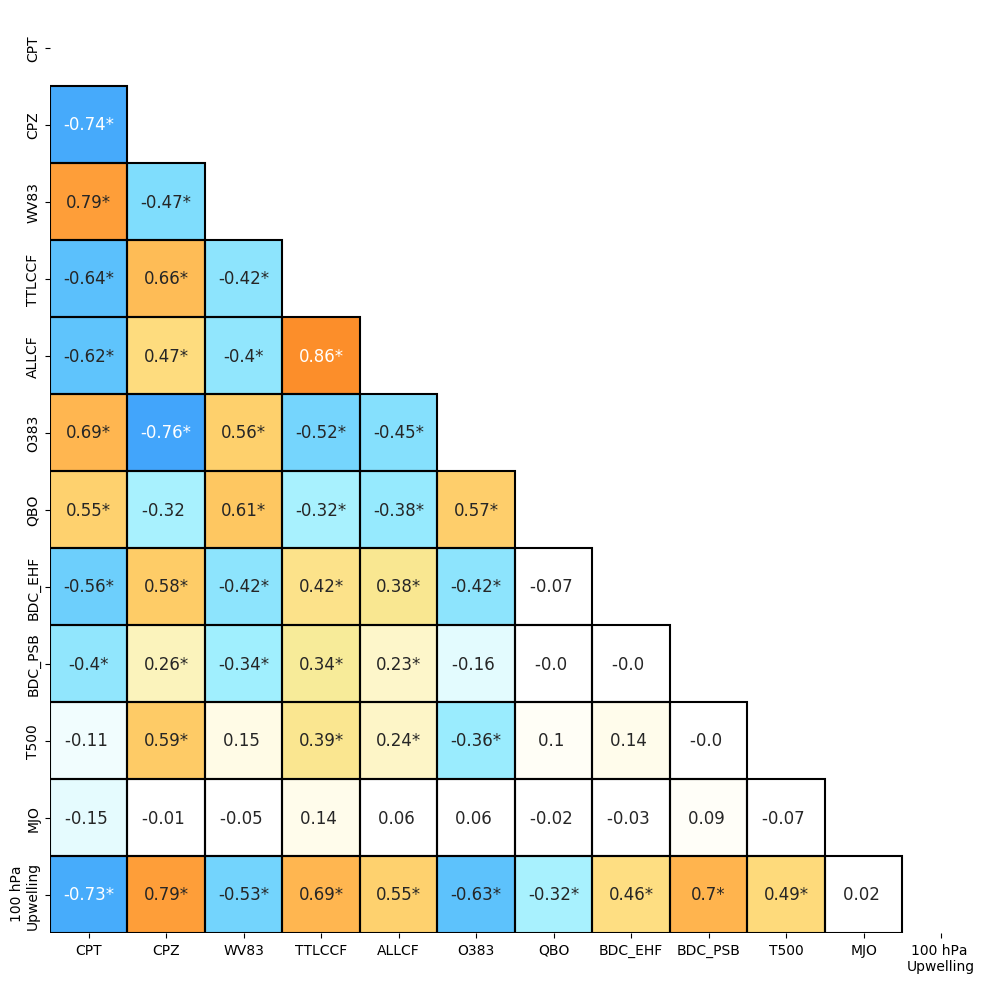

In [8]:
# Standardize predictors and targets so that coefficients in MLR model can be compared
predictors_and_target_df = [all_detrended_timeseries[i]/np.nanstd(all_detrended_timeseries[i]) for i in range(len(all_detrended_timeseries))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target_df),
                                        columns=['CPT','CPZ', 'WV83', 'TTLCCF', 'ALLCF', 'O383', 
                                                 'QBO', 'BDC_EHF', 'BDC_PSB', 'T500', 'MJO', 
                                                 '100 hPa \nUpwelling'])

# Create Correlation and Siginficance Matrices
corr_matrx = correlation_matrix_creator(predictors_and_target_df)

# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrx)
X = predictors_and_target_df[['QBO', 'T500', 'MJO']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['WV83']
Y3 = predictors_and_target_df['TTLCCF']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']
Y6 = predictors_and_target_df['O383']

#lr_table(X, Y1, Y3, Y2, Y4, Y5)

X1 = predictors_and_target_df[['BDC_EHF', 'BDC_PSB']]
lm = pg.linear_regression(X1, Y2, relimp=True)
display(lm)
#0.644787

<Figure size 600x600 with 0 Axes>

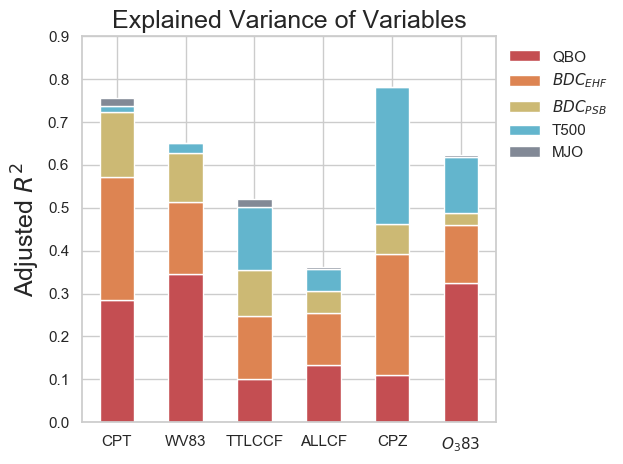

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

CPT = predictors_and_target_df['CPT']
CPZ = predictors_and_target_df['CPZ']
WV = predictors_and_target_df['WV83']
TTLCCF = predictors_and_target_df['TTLCCF']
AllCF = predictors_and_target_df['ALLCF']
O3 = predictors_and_target_df['O383']

targets = [CPT, WV, TTLCCF, AllCF, CPZ, O3]
partitioned_variances = []
residual_targets = []

for residual_idx in range(0,3):
    if residual_idx == 0:
        LSD = predictors_and_target_df[['QBO', 'BDC_EHF', 'BDC_PSB', 'T500', 'MJO']]
    elif residual_idx == 1:
        LSD = predictors_and_target_df[['QBO', 'BDC_EHF']]
    elif residual_idx == 2:
        LSD = predictors_and_target_df[['QBO', 'BDC_EHF', 'T500', 'MJO']]
    
    residual_targets_i = []
    for target_idx, TargetVariable in enumerate(targets):
        #if target_idx == 1:
        #    # if you are trying to predict water vapor, make the water vapor lag the predictors by 1 month
        #    LSD_ = LSD[:-1]
        #    TargetVariable_ = TargetVariable[:-1]
        #    lm = pg.linear_regression(LSD_, TargetVariable_, add_intercept=True, relimp=True)
        #else:
        lm = pg.linear_regression(LSD, TargetVariable, add_intercept=True, relimp=True)
    
        adj_R2 = lm.adj_r2[0]   
        partitioned_adjr2 = lm.relimp.values[1:]
        partitioned_adjr2 = partitioned_adjr2/np.nansum(partitioned_adjr2)
        partitioned_adjr2 = partitioned_adjr2*adj_R2

        if residual_idx == 0:
            recreation = (lm.coef[0] + LSD.QBO*lm.coef[1] + LSD.BDC_EHF*lm.coef[2] + LSD.BDC_PSB*lm.coef[3] + LSD.T500*lm.coef[4] + LSD.MJO*lm.coef[5])
        if residual_idx == 1:
            recreation = (lm.coef[0] + LSD.QBO*lm.coef[1] + LSD.BDC_EHF*lm.coef[2])
        if residual_idx == 2:
            recreation = (lm.coef[0] + LSD.QBO*lm.coef[1] + LSD.BDC_EHF*lm.coef[2] + LSD.T500*lm.coef[3] + LSD.MJO*lm.coef[4])
        residual = TargetVariable - recreation
        residual_targets_i.append(residual)
        if residual_idx == 0:
            partitioned_variances.append(partitioned_adjr2)
    residual_targets.append(residual_targets_i)
residual_targets = np.array(residual_targets)
        

partitioned_variances = pd.DataFrame(partitioned_variances, 
                                    index=['CPT', 'WV83', 'TTLCCF', 'ALLCF', 'CPZ', '$O_{3}83$',], 
                                    columns=['QBO', '$BDC_{EHF}$','$BDC_{PSB}$', 'T500', 'MJO'])

#barchart colors
#bar_colors = ['#e77c8d', '#c69255','#98a255', '#5fa5c5', '#828996']
bar_colors = ['#c44e52', '#dd8452','#ccb974', '#63b5cd', '#828996']
sequential_colors = sns.color_palette(bar_colors, 5)
# set plot style: grey grid in the background:
sns.set(style="whitegrid")

# set the figure size
plt.figure(figsize=(6, 6))

# sum of total explained variance (equal to models R2)
total = np.nansum(partitioned_variances, axis=1,)

#create stacked bar chart
partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0)
plt.legend(loc='upper left', bbox_to_anchor=(1., 1.0), frameon=False)
plt.ylim(0,0.9)
plt.ylabel('Adjusted $R^{2}$', fontsize=18)
plt.title('Explained Variance of Variables', fontsize=18)

plt.tight_layout()

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/TTLVariabilityFinalFigures/Figure3.png', dpi=300)

# Residual Timeseries

In [10]:
# The residual targets we want to predict
cpt_residual = residual_targets[0,0]
wv_residual = residual_targets[0,1]
tcf_residual = residual_targets[0,2]
acf_residual = residual_targets[0,3]
cpz_residual = residual_targets[0,4]
o3_residual = residual_targets[0,5]

# also get global zonal mean temp anom data
temp_prof_anoms = temp_profs - np.nanmean(temp_profs, axis=0)
temp_prof_anoms_zm = np.nanmean(temp_prof_anoms, axis=3)
temp_profs_ts = np.reshape(temp_prof_anoms_zm, (16*12, 72, 350))
global_zm_temp_anoms = np.nanmean(np.reshape(temp_profs_ts, (192, 36,2,350)), axis=2)[5:]

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


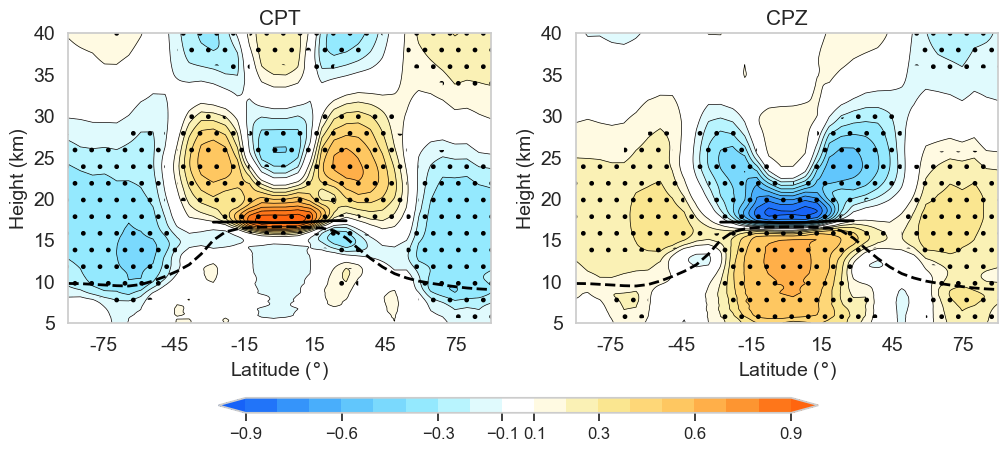

In [13]:
from matplotlib.colors import LinearSegmentedColormap
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)
def detrender(time, ts):
    slope = stats.linregress(time, ts)[0]
    intercept = stats.linregress(time, ts)[1]
    recreation = intercept + slope*time
    ts_detrended = ts - recreation
    return(ts_detrended)

levels = np.array([-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9])/10
def profile_correlator(pc, varmap):
    pc = pc/np.nanstd(pc)
    r_map = []
    sig_map = []
    for x in range(0, len(varmap[0,:])):
        r_x = []
        sig_x = []
        for y in range(len(varmap[0,0,:])):        
            temp_series = varmap[:,x,y]
            temp_series_no_nans = temp_series[~np.isnan(temp_series)]
            pc_non_nans = pc[~np.isnan(temp_series)]
            time = np.arange(2006 + 5/12, 2022, 1/12)
            time_non_nans = time[~np.isnan(temp_series)]
            
            try:
                temp_series_no_nans = detrender(time_non_nans, temp_series_no_nans)
                N = len(temp_series)
                r = stats.pearsonr(temp_series_no_nans[:], pc_non_nans[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series_no_nans[1:], temp_series_no_nans[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc_non_nans[1:], pc_non_nans[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
            except:
                r = np.NaN
                significant = 0
            
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

cpt_corr_map = profile_correlator(all_detrended_timeseries[0], global_zm_temp_anoms)
cpz_corr_map = profile_correlator(all_detrended_timeseries[1], global_zm_temp_anoms)
corr_maps = [cpt_corr_map, cpz_corr_map]
titles = ['CPT', 'CPZ']

fig, axs = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    corr_map = corr_maps[i][0]
    sig_map = corr_maps[i][1]
    axs[i].set_title(titles[i], fontsize=15)
    im = axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, cmap=custom_cmap, extend='both')
    axs[i].contour(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, colors='black', 
                linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"), extend='both')
    axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), sig_map, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axs[i].plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
    axs[i].plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
    axs[i].set_yticks([5,10,15,20,25,30, 35,40])
    axs[i].set_yticklabels(labels=['5','10','15','20','25','30', '35', '40'], fontsize=14)
    axs[i].set_xticks([-75, -45, -15,  15, 45, 75])
    axs[i].set_xticklabels(labels=['-75', '-45', '-15',  '15', '45', '75'], fontsize=14)
    axs[i].grid(color='black', alpha=0.25)
    axs[i].set_xlabel('Latitude ($\degree$)', fontsize=14)
    axs[i].set_ylabel('Height (km)', fontsize=14)
    
fig.subplots_adjust(bottom=0.3)
cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
fig.colorbar(im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=12)


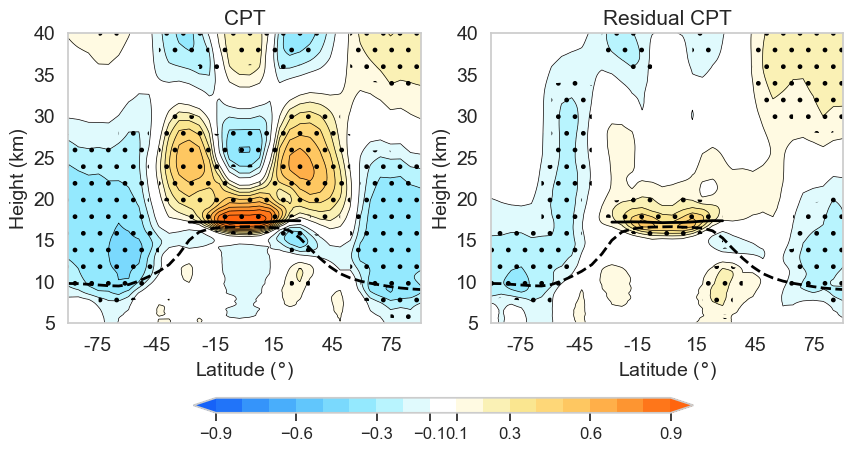

In [14]:
cpt_related_timeseries = [CPT.values, residual_targets[0,0]]
titles = ['CPT', 'Residual CPT']

fig, axs = plt.subplots(1,2, figsize=(10,5))
for i in range(2):
    corr_map, sig_map = profile_correlator(cpt_related_timeseries[i], global_zm_temp_anoms)
    axs[i].set_title(titles[i], fontsize=15)
    im = axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, cmap=custom_cmap, extend='both')
    axs[i].contour(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, colors='black', 
                linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"), extend='both')
    axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), sig_map, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axs[i].plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
    axs[i].plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
    axs[i].set_yticks([5,10,15,20,25,30, 35,40])
    axs[i].set_yticklabels(labels=['5','10','15','20','25','30', '35', '40'], fontsize=14)
    axs[i].set_xticks([-75, -45, -15,  15, 45, 75])
    axs[i].set_xticklabels(labels=['-75', '-45', '-15',  '15', '45', '75'], fontsize=14)
    axs[i].set_xlabel('Latitude ($\degree$)', fontsize=14)
    axs[i].set_ylabel('Height (km)', fontsize=14)
    axs[i].grid(color='black')
    
fig.subplots_adjust(bottom=0.3)
cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
fig.colorbar(im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=12)

for x in range(2):
    axs[i].grid(color='black', alpha=0.3)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/TTLVariabilityFinalFigures/Figure4.png', dpi=300)

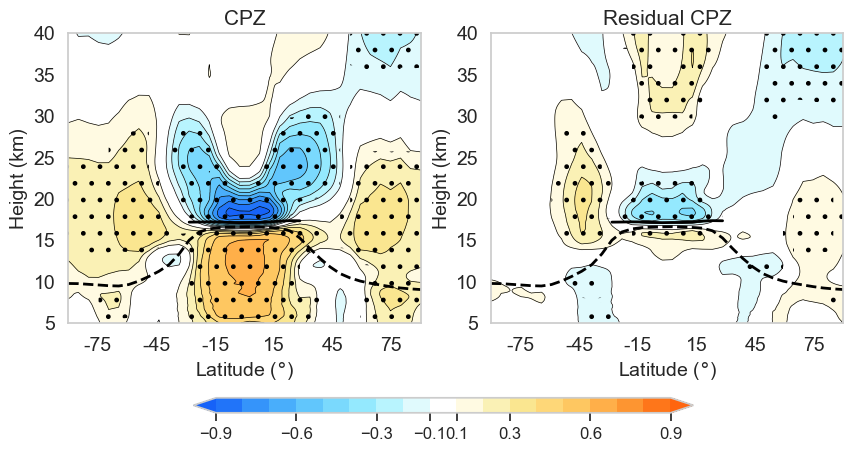

In [15]:
cpz_related_timeseries = [CPZ.values, residual_targets[0,4]]
titles = ['CPZ', 'Residual CPZ']

fig, axs = plt.subplots(1,2, figsize=(10,5))
for i in range(2):
    corr_map, sig_map = profile_correlator(cpz_related_timeseries[i], global_zm_temp_anoms)
    axs[i].set_title(titles[i], fontsize=15)
    im = axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, cmap=custom_cmap, extend='both')
    axs[i].contour(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, colors='black', 
                linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"), extend='both')
    axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), sig_map, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axs[i].plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
    axs[i].plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
    axs[i].set_yticks([5,10,15,20,25,30, 35,40])
    axs[i].set_yticklabels(labels=['5','10','15','20','25','30', '35', '40'], fontsize=14)
    axs[i].set_xticks([-75, -45, -15,  15, 45, 75])
    axs[i].set_xticklabels(labels=['-75', '-45', '-15',  '15', '45', '75'], fontsize=14)
    axs[i].grid(color='black', alpha=0.25)
    axs[i].set_xlabel('Latitude ($\degree$)', fontsize=14)
    axs[i].set_ylabel('Height (km)', fontsize=14)
    
fig.subplots_adjust(bottom=0.3)
cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
fig.colorbar(im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=12)

for x in range(2):
    axs[i].grid(color='black', alpha=0.3)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/TTLVariabilityFinalFigures/Figure5.png', dpi=300)